In [1]:
import os, sys, fnmatch, re, itertools, warnings
import pandas as pd
import numpy as np
import seaborn as sns
from gurobipy import *
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from numpy import sqrt
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pmdarima.arima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
init_notebook_mode(connected=True)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# Get Data

In [2]:
file = '/Users/scott/Projects/MR/dataset.xlsx'
data = pd.read_excel(file, header=1)
data.head()

,Ticket Created Date,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer count - Sub,Customer count - One
0,2016-04-21,533,984,507,239,240
1,2016-04-20,658,6035,485,225,210
2,2016-04-19,778,2450,500,196,231
3,2016-04-18,743,2502,527,192,240
4,2016-04-17,925,3080,488,217,209


In [12]:
# Clean Data
data = data.set_index(['Ticket Created Date'])
df = data.sort_index(ascending=True)
df = df.rename(columns={'Customer count - Sub': 'Customer Count - Sub', 
                        'Customer count - One': 'Customer Count - One'})
df.head()

,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer Count - Sub,Customer Count - One
Ticket Created Date,,,,,
2015-11-24,907,2947,717,307,386
2015-11-25,846,4290,641,306,359
2015-11-26,636,908,759,438,490
2015-11-27,848,1424,1359,387,465
2015-11-28,1063,1975,632,247,315


In [13]:
# Create Features
df['DOW'] = df.index.dayofweek
df['Order Count - Total'] = df['Order Count - Sub'] + df['Order Count - One']
df['Customer Count - Total'] = df['Customer Count - One'] + df['Customer Count - Sub']

In [14]:
# Create lag features for order count total
def create_oct_lag(df):
    for x in list(range(1,11)):
        col_name = 'OCT' + str(x)
        df[col_name] = df['Order Count - Total'] - df['Order Count - Total'].shift(x)
    return df

In [15]:
# Create lag features for customer count total
def create_cc_lag(df):
    for x in list(range(1,11)):
        col_name = 'CC' + str(x)
        df[col_name] = df['Order Count - Total'] - df['Order Count - Total'].shift(x)
    return df

In [16]:
create_oct_lag(df)
create_cc_lag(df)

,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer Count - Sub,Customer Count - One,DOW,Order Count - Total,Customer Count - Total,OCT1,OCT2,...,CC1,CC2,CC3,CC4,CC5,CC6,CC7,CC8,CC9,CC10
Ticket Created Date,,,,,,,,,,,,,,,,,,,,,
2015-11-24,907,2947,717,307,386,1,3664,693,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-25,846,4290,641,306,359,2,4931,665,1267.0,NaN,...,1267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-26,636,908,759,438,490,3,1667,928,-3264.0,-1997.0,...,-3264.0,-1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-27,848,1424,1359,387,465,4,2783,852,1116.0,-2148.0,...,1116.0,-2148.0,-881.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-28,1063,1975,632,247,315,5,2607,562,-176.0,940.0,...,-176.0,940.0,-2324.0,-1057.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-29,1070,2352,735,297,378,6,3087,675,480.0,304.0,...,480.0,304.0,1420.0,-1844.0,-577.0,NaN,NaN,NaN,NaN,NaN
2015-11-30,832,1988,695,267,375,0,2683,642,-404.0,76.0,...,-404.0,76.0,-100.0,1016.0,-2248.0,-981.0,NaN,NaN,NaN,NaN
2015-12-01,845,1930,617,234,346,1,2547,580,-136.0,-540.0,...,-136.0,-540.0,-60.0,-236.0,880.0,-2384.0,-1117.0,NaN,NaN,NaN
2015-12-02,755,4718,671,265,333,2,5389,598,2842.0,2706.0,...,2842.0,2706.0,2302.0,2782.0,2606.0,3722.0,458.0,1725.0,NaN,NaN


In [124]:
feature_selection(df.dropna(inplace=False), 2)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['Order Count - Sub', 'Order Count - Total']

In [5]:
# Splits data based on split(percentage)
def train_test_split(df, split):
    trainsize = int(len(data) * split)
    return data[:trainsize], data[trainsize:]

# EDA

## Explore Data

In [319]:
def line_plot(df, title, ytitle, xtitle='Date'):
    traces = []
    for cols in df.columns:
        df2 = df[cols]
        traces.append(
            go.Scatter(
                x = df2.index,
                y = df2,
                mode = 'lines',
                opacity = 0.7,
                marker = {'size':6},
                name =  cols
            )
        )
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=xtitle
        ),
        yaxis=dict(
            title=ytitle
        ),
        bargap=0.1,
    )
    data = traces
    fig = go.Figure(data=data, layout=layout)
    return iplot(fig, filename='basic-line')

In [320]:
data['Total Tickets Opened'].describe()

count     150.000000
mean      727.073333
std       197.137233
min       354.000000
25%       583.750000
50%       729.500000
75%       845.750000
max      1734.000000
Name: Total Tickets Opened, dtype: float64

In [321]:
line_plot(df[['Total Tickets Opened']], 'Daily Tickets', 'Ticket Count')

In [322]:
# Distribution of data
data = [go.Histogram(x=df['Total Tickets Opened'])]
layout = go.Layout(
    title='Ticket Distribution',
    xaxis=dict(
        title='Value'
    ),
    yaxis=dict(
        title='Count'
    ),
    bargap=0.1,
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic histogram')

In [323]:
df.dropna(inplace=False).corr()

,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer Count - Sub,Customer Count - One,DOW,Order Count - Total,Customer Count - Total,OCT1,OCT2,...,CC1,CC2,CC3,CC4,CC5,CC6,CC7,CC8,CC9,CC10
Total Tickets Opened,1.000000,0.391002,0.322095,0.068864,0.171591,0.192076,0.413498,0.136180,0.337709,0.624996,...,0.337709,0.624996,0.404679,0.174797,0.246192,0.096426,0.120295,0.347720,0.629474,0.419694
Order Count - Sub,0.391002,1.000000,0.022896,-0.057554,-0.130863,-0.175172,0.997156,-0.106381,0.739053,0.827611,...,0.739053,0.827611,0.693217,0.701066,0.823931,0.764978,0.201381,0.747463,0.830608,0.702005
Order Count - One,0.322095,0.022896,1.000000,0.555103,0.875325,0.205935,0.098183,0.796858,0.269577,0.054581,...,0.269577,0.054581,0.106182,-0.014056,0.098356,0.003459,0.113914,0.261760,0.051066,0.115872
Customer Count - Sub,0.068864,-0.057554,0.555103,1.000000,0.669527,0.092332,-0.015442,0.897972,0.083603,-0.129762,...,0.083603,-0.129762,-0.009275,-0.067825,0.018477,-0.016133,0.098996,0.093371,-0.125509,0.008766
Customer Count - One,0.171591,-0.130863,0.875325,0.669527,1.000000,0.115390,-0.064274,0.928083,0.079488,-0.081859,...,0.079488,-0.081859,-0.036627,-0.062412,-0.053293,-0.080054,0.067264,0.072065,-0.080569,-0.029141
DOW,0.192076,-0.175172,0.205935,0.092332,0.115390,1.000000,-0.158846,0.114649,0.090195,0.138003,...,0.090195,0.138003,-0.248531,-0.721618,-0.040975,-0.035423,-0.004359,0.087448,0.124118,-0.246923
Order Count - Total,0.413498,0.997156,0.098183,-0.015442,-0.064274,-0.158846,1.000000,-0.045819,0.755998,0.827943,...,0.755998,0.827943,0.698054,0.696802,0.827580,0.761743,0.209049,0.763780,0.830662,0.707532
Customer Count - Total,0.136180,-0.106381,0.796858,0.897972,0.928083,0.114649,-0.045819,1.000000,0.089003,-0.113549,...,0.089003,-0.113549,-0.026349,-0.070977,-0.022310,-0.055515,0.089479,0.089503,-0.110652,-0.012870
OCT1,0.337709,0.739053,0.269577,0.083603,0.079488,0.090195,0.755998,0.089003,1.000000,0.550258,...,1.000000,0.550258,0.359613,0.548812,0.622800,0.413089,0.109743,0.982595,0.550514,0.365549
OCT2,0.624996,0.827611,0.054581,-0.129762,-0.081859,0.138003,0.827943,-0.113549,0.550258,1.000000,...,0.550258,1.000000,0.522119,0.424414,0.649985,0.621054,0.191202,0.552316,0.985478,0.531827


<Figure size 432x288 with 0 Axes>

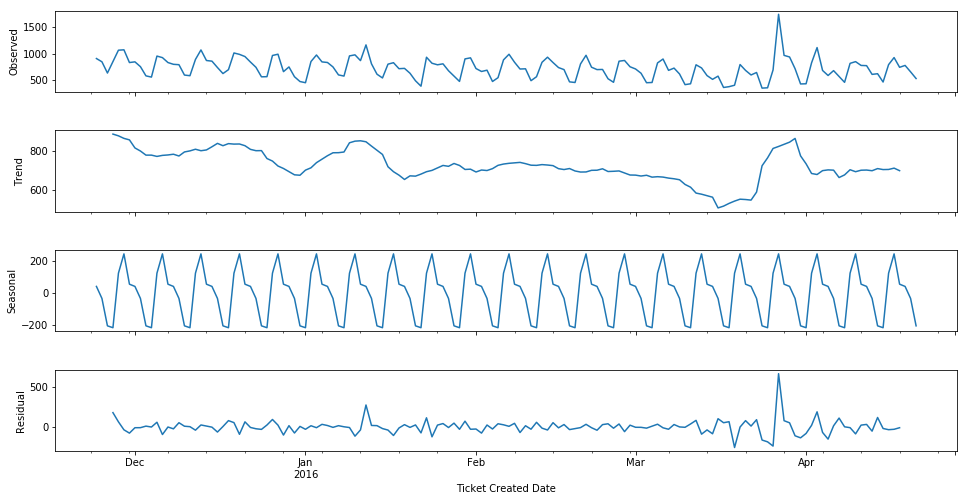

In [324]:
# Remove trend and seasonality
decomposition = seasonal_decompose(df['Total Tickets Opened'], freq=7)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [325]:
# Explore residuals
residuals = pd.DataFrame(decomposition.resid)
residuals 
line_plot(residuals, 'Residuals', 'Ticket Count')

## Test Stationarity

In [326]:
def test_stationarity(timeseries, cutoff = 0.01):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd = timeseries.rolling(10).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Test Stationarity')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[0] < dftest[4]['1%']:
        print('Reject the null hypothesis; it is stationary')
    else:
        print('Fail to reject the null hypothesis; it is not stationary')
    print('\n')    
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpsstest[0] < kpsstest[3]['1%']:
        print('Reject the null hypothesis; it is stationary')
    else:
        print('Fail to reject the null hypothesis; it is not stationary')

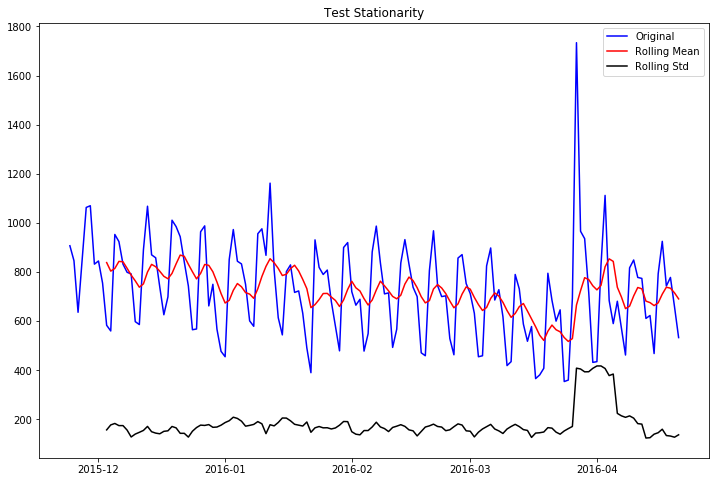

Results of Dickey-Fuller Test:
Test Statistic                  -2.116349
p-value                          0.237992
#Lags Used                      14.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64
Fail to reject the null hypothesis; it is not stationary


Results of KPSS Test:
Test Statistic            0.636808
p-value                   0.019290
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis; it is stationary


In [327]:
test_stationarity(df['Total Tickets Opened'])

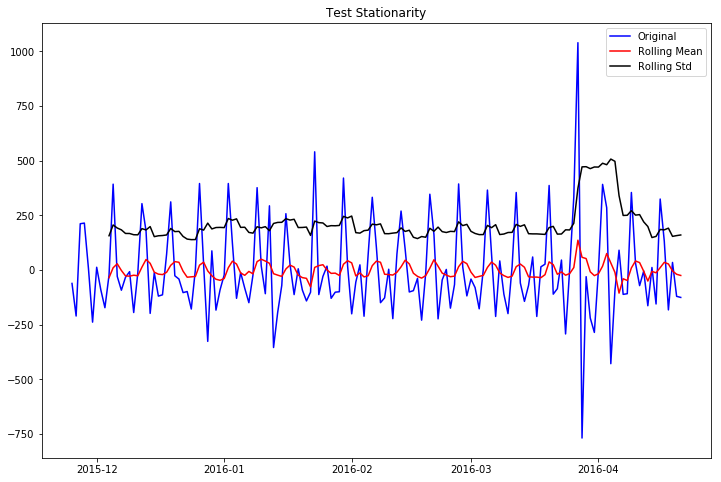

Results of Dickey-Fuller Test:
Test Statistic                -5.919877e+00
p-value                        2.521208e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.350000e+02
Critical Value (1%)           -3.479743e+00
Critical Value (5%)           -2.883198e+00
Critical Value (10%)          -2.578320e+00
dtype: float64
Reject the null hypothesis; it is stationary


Results of KPSS Test:
Test Statistic            0.069949
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis; it is stationary


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value



In [328]:
# First Difference Stationarity
df['First Difference'] = df['Total Tickets Opened'] - df['Total Tickets Opened'].shift(1)  
test_stationarity(df['First Difference'].dropna(inplace=False))

## Correlation and Feature Engineering

In [329]:
def heatmap_corr(df): 
    labels = [x for x in df.corr().columns]
    trace = go.Heatmap(
        z=df.corr().values,
        x=labels,
        y=labels
        )
    layout = go.Layout(
        title='Heatmap of Correlation',
        yaxis=go.layout.YAxis(
        automargin=True
        )
    )
    data = [trace]
    fig = go.Figure(data=data, layout=layout)

    return iplot(fig, filename='heatmap')

In [330]:
heatmap_corr(df[['Total Tickets Opened', 'Order Count - Sub', 'Order Count - One', 'Customer Count - Sub', 'Customer Count - Total']])

In [331]:
heatmap_corr(df)

In [332]:
def corr_plot(x, y):
    trace = go.Scatter(
        x = x,
        y = y,
        mode = 'markers'
    )
    data = [trace]
    return iplot(data, filename='basic-scatter')

In [333]:
corr_plot(df['Total Tickets Opened'], df['Customer Count - Sub'])

In [338]:
def corr_plot_DOW(x_col, y_col):
    fig = {
        'data': [
            {
                'x': df[df['DOW']==day][x_col],
                'y': df[df['DOW']==day][y_col],
                'name': day, 'mode': 'markers',
            } for day in list(range(7))
        ],
        'layout': {
            'xaxis': {'title': x_col, 'type': 'log'},
            'yaxis': {'title': 'Ticket Count'}
        }
    }
    return iplot(fig, filename='grouped-scatter')

In [341]:
corr_plot_DOW('Order Count - Total', 'Total Tickets Opened')

In [343]:
corr_plot_DOW('Customer Count - Sub', 'Total Tickets Opened')

# Seasonal Persistence Model

In [231]:
splits = [.5, .6, .7, .8, .9]
def seasonal_persistence(df):
    results_dict = {'Splits': list(), 'RMSE': list()}
    
    for split in splits: 
        train, test = train_test_split(df, split)
        #Evaluate up to the last 10 weeks mean
        weeks = [i for i in range(1,30)]
        best_rmse = 10000
        for week in weeks:
            try:
                # Walk forward validation
                history = [x for x in train.values]
                predictions = []
                for i in range(len(test)):
                    #collect observation
                    obs = []
                    for d in range(1, week+1):
                        obs.append(history[-(d*7)])
                    #make prediction
                    yhat = np.mean(obs)
                    predictions.append(yhat)
                    # Observation
                    history.append(test[i])
                future_forecast = pd.DataFrame(predictions,
                                   index=test.index,
                                   columns=['Predictions'])
                rmse = sqrt(mean_squared_error(test, predictions))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_forecast = future_forecast
                else:
                    continue
            except:
                results_dict['Splits'].append(split)
                results_dict['RMSE'].append(best_rmse)
                break
    return results_dict

In [232]:
sp_results = seasonal_persistence(df['Total Tickets Opened'])

In [233]:
sp_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [141.69202371105203,
  155.71435771282194,
  176.68818363464806,
  176.40035441301427,
  56.481041712389356]}

# Holts Winter Model

In [115]:
# Holts Winter
def holts(data):
    results_dict = {'Splits': list(), 'RMSE': list()}
    for split in splits: 
        train, test = train_test_split(data, split)
   
        # Create and fit auto arima model
        hw_model = ExponentialSmoothing(train, seasonal_periods=7, 
                                        trend='add', seasonal='add', 
                                        damped=True).fit(use_boxcox=False, remove_bias=False)

        # Make predictions and plot
        forecast = hw_model.predict(start=test.index[0], end=test.index[-1])
        future_forecast = pd.DataFrame(forecast,
                                       index=test.index,
                                       columns=['Predictions'])
        pd.concat([test, future_forecast], axis=1).plot()

        #Print RMSE
        rmse = sqrt(mean_squared_error(test, future_forecast))
        print('RMSE: %f' % rmse)

        #Determining Forecast Bias
        residuals = [test[i]-forecast[i] for i in range(len(test))] 
        bias = sum(residuals) * 1.0/len(test)
        print('Bias: %f' % bias)

        # Summary Statistics of bias
        print(pd.DataFrame(residuals).describe())
        
        results_dict['Splits'].append(split)
        results_dict['RMSE'].append(rmse)
    return results_dict

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 143.757992
Bias: -32.818118
                0
count   75.000000
mean   -32.818118
std    140.904408
min   -472.418846
25%    -81.952015
50%    -51.573155
75%     14.357229
max    828.444782


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 155.024280
Bias: -39.125206
                0
count   60.000000
mean   -39.125206
std    151.271713
min   -459.298925
25%    -83.348476
50%    -51.922218
75%     -6.089793
max    819.287412


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 172.558173
Bias: 13.870443
                0
count   45.000000
mean    13.870443
std    173.943370
min   -406.365552
25%    -66.950288
50%    -11.615138
75%     63.049712
max    872.049712


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 241.102578
Bias: 169.004781
                0
count   30.000000
mean   169.004781
std    174.892589
min     -1.557374
25%     75.974827
50%    135.996997
75%    196.166990
max    951.788440


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 109.124133
Bias: 38.738059
                0
count   15.000000
mean    38.738059
std    105.597480
min   -212.983050
25%     25.859039
50%     33.822402
75%    105.933109
max    206.713192


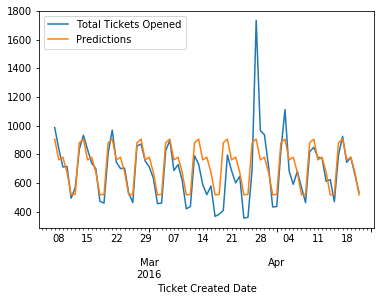

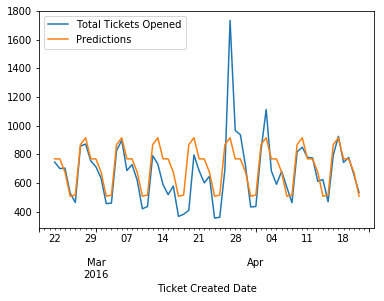

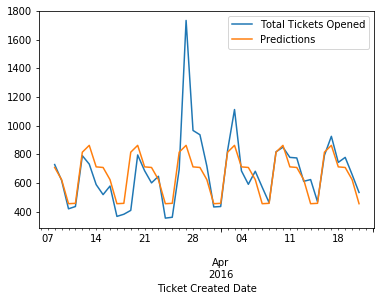

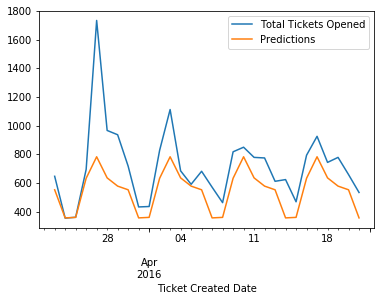

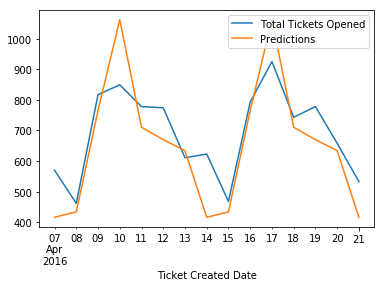

In [116]:
hw_results = holts(df['Total Tickets Opened'])

In [117]:
hw_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [143.7579922586709,
  155.0242799851283,
  172.55817263454307,
  241.10257783666648,
  109.1241330333621]}

# SARIMAX Model

## Feature Selection for SARIMAX

In [3]:
# Use Recursive feature selection
def feature_selection(df, num_features):
    df2 = df #.drop(columns=['Order Count - Total', 'Customer count - Total'])
    feat_list = []
    X = df2.iloc[:,1:]
    y = df2.iloc[:,:1]
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), num_features)
    fit = rfe.fit(X, y)

    # print('Features:')
    names = df2.columns.values[1:]
    for x in range(len(fit.support_)):
        if fit.support_[x]:
            # print(names[x])
            feat_list.append(names[x])
    ticks = [i for i in range(len(names))]
    # plt.bar(ticks, fit.ranking_)
    # plt.xticks(ticks, names, rotation=90)
    # plt.show()
    return feat_list

## Auto Arima Model

In [137]:
def autoarima_model(en, split, count, ex=None):
    train_size = int(len(en) * split)
    endog_data = en
    train, test = endog_data[:train_size], endog_data[train_size:]
    if ex is None:
        exog_data=None
    else:
        exog_data = ex
        exog_train, exog_test = exog_data[0:train_size], exog_data[train_size:]
        
    # Create and fit auto arima model
    stepwise_model = auto_arima(endog_data, exogenous=exog_data, start_p=1, start_q=1,
                               max_p=3, max_q=7, m=7,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    stepwise_model.aic()
    stepwise_model.fit(train)
    
    # Make predictions and plot
    forecast = stepwise_model.predict(n_periods=len(test))
    future_forecast = pd.DataFrame(forecast,
                                   index=test.index,
                                   columns=['Predictions' + str(count)])
    pd.concat([test, future_forecast], axis=1).plot()
    print(stepwise_model)
    
    #Print RMSE
    rmse = sqrt(mean_squared_error(test, future_forecast))
    print('RMSE: %f' % rmse)
    
    #Determining Forecast Bias
    residuals = [test[i]-forecast[i] for i in range(len(test))] 
    bias = sum(residuals) * 1.0/len(test)
    print('Bias: %f' % bias)
    
    # Summary Statistics of bias
    print(pd.DataFrame(residuals).describe())
    
    return rmse, stepwise_model, residuals, pd.concat([test, future_forecast], axis=1)

## Function to Return best Models

In [120]:
# Find out which feature amount is best
def aa_model(df):
    results_dict = {'Splits': list(), 'RMSE': list()}

    for split in splits: 
        best_rmse = 10000
        for x in list(range(1,2)):
            features_list = feature_selection(df.dropna(inplace=False), x)
            ex = df[features_list].dropna(inplace=False)
            en = df['Total Tickets Opened'][len(df)-len(ex):]
            try:
                rmse, stepwise_model, residuals, predictions = autoarima_model(en=en,
                                                                               split=split,
                                                                               count=x,
                                                                               ex=ex)
                # Create dataset of all predictions
                if x == 1:
                    all_preds = predictions
                else:
                    all_preds = pd.merge(all_preds, predictions[['Predictions' + str(x)]], 
                                how='left', left_index=True, right_index=True)
                # Keep metrics of the best performing models    
                if rmse < best_rmse:
                    best_features = features_list
                    best_rmse = rmse
                    best_model = stepwise_model
                    best_residuals = residuals
                    best_predictions = predictions
                else:
                    continue
            except:
                continue

        results_dict['Splits'].append(split)
        results_dict['RMSE'].append(best_rmse)
    return results_dict

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1765.347, BIC=1783.082, Fit time=0.740 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.991, BIC=1861.859, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1818.965, BIC=1833.744, Fit time=0.310 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1768.818, BIC=1783.597, Fit time=0.949 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1763.849, BIC=1784.540, Fit time=1.111 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1799.956, BIC=1817.691, Fit time=0.714 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1811.678, BIC=1826.457, Fit time=0.214 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1763.027, BIC=1789.629, Fit time=1.953 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1759.479, BIC=1780.170, Fit time=0.897 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.425, BIC=1864.249, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1817.191, BIC=1834.925, Fit time=0.463 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1761.406, BIC=1779.140, Fit time=0.713 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1758.257, BIC=1781.904, Fit time=1.312 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1793.922, BIC=1814.613, Fit time=1.026 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1806.982, BIC=1824.717, Fit time=0.262 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1762.054, BIC=1791.612, Fit time=2.471 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1715.517, BIC=1738.935, Fit time=1.172 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1801.865, BIC=1816.501, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1769.157, BIC=1789.648, Fit time=0.595 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.464, BIC=1737.955, Fit time=1.220 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1714.488, BIC=1740.833, Fit time=1.613 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1748.102, BIC=1771.520, Fit time=1.255 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1713.863, BIC=1743.135, Fit time=2.504 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1716.481, BIC=1742.827, Fit time=1.939 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.512, BIC=1743.857, Fit time=1.453 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1802.230, BIC=1819.793, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1771.049, BIC=1794.467, Fit time=0.937 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1724.243, BIC=1747.661, Fit time=1.487 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1725.244, BIC=1754.517, Fit time=1.797 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1762.333, BIC=1785.751, Fit time=0.489 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1736.991, BIC

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1719.510, BIC=1748.783, Fit time=1.568 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1804.230, BIC=1824.721, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1773.049, BIC=1799.394, Fit time=0.945 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1723.647, BIC=1749.992, Fit time=1.759 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1718.576, BIC=1750.776, Fit time=2.412 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1752.090, BIC=1781.363, Fit time=1.838 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1764.009, BIC=1790.354, Fit time=0.571 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1737.241, BIC=1775.295, Fit time=2.926 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1721.746, BIC=1753.946, Fit time=1.751 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1806.230, BIC=1829.648, Fit time=0.043 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1775.049, BIC=1804.322, Fit time=1.118 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1727.034, BIC=1756.307, Fit time=1.838 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1722.620, BIC=1757.747, Fit time=2.345 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1766.021, BIC=1795.293, Fit time=0.621 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1742.272, BIC

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1675.537, BIC=1710.221, Fit time=1.937 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1742.356, BIC=1768.369, Fit time=0.070 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1713.212, BIC=1745.006, Fit time=1.412 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.191, BIC=1710.985, Fit time=1.757 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.359, BIC=1718.933, Fit time=2.267 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1705.765, BIC=1737.559, Fit time=0.650 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1686.294, BIC=1726.759, Fit time=3.053 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.604, BIC=1717.179, Fit time=2.114 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1744.111, BIC=1773.014, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1715.211, BIC=1749.895, Fit time=1.711 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.764, BIC=1715.449, Fit time=1.901 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1682.916, BIC=1723.380, Fit time=2.495 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1708.341, BIC=1743.025, Fit time=0.716 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1688.308, BIC=1731.663, Fit time=3.191 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1671.071, BIC=1711.536, Fit time=2.325 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1683.909, BIC=1724.374, Fit time=2.278 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1746.037, BIC=1777.830, Fit time=0.065 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1717.067, BIC=1754.641, Fit time=1.948 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.400, BIC=1717.974, Fit time=2.363 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1675.230, BIC=1715.695, Fit time=2.580 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1704.126, BIC=1741.700, Fit time=1.219 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1687.514, BIC=1730.870, Fit time=3.385 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1717.803, BIC=1752.487, Fit time=0.607 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1684.886, BIC=1731.131, Fit time=3.199 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.169, BIC=1729.524, Fit time=2.320 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.037, BIC=1782.721, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.067, BIC=1759.531, Fit time=2.361 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.992, BIC=1725.456, Fit time=2.433 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1686.041, BIC=1729.396, Fit time=2.598 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1719.803, BIC=1757.378, Fit time=0.722 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1690.943, BIC=1737.189, Fit time=3.293 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1713.710, BIC=1751.284, Fit time=1.967 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.808, BIC=1734.054, Fit time=2.500 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1749.862, BIC=1787.437, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.748, BIC=1763.103, Fit time=2.439 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.871, BIC=1729.226, Fit time=2.622 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.028, BIC=1733.274, Fit time=2.926 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1720.872, BIC=1761.337, Fit time=0.747 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1716.345, BIC=1756.810, Fit time=2.019 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.823, BIC=1731.959, Fit time=2.649 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.606, BIC=1789.071, Fit time=0.071 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1716.459, BIC=1762.705, Fit time=2.669 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.834, BIC=1727.080, Fit time=3.007 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.687, BIC=1730.823, Fit time=3.166 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1715.580, BIC=1758.935, Fit time=0.809 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1717.016, BIC=1760.371, Fit time=2.153 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.823, BIC=1736.850, Fit time=2.745 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1750.606, BIC=1793.961, Fit time=0.073 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1718.458, BIC=1767.594, Fit time=2.804 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.834, BIC=1731.970, Fit time=3.183 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1683.687, BIC=1735.714, Fit time=3.315 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1717.580, BIC=1763.826, Fit time=0.854 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1719.016, BIC=1765.262, Fit time=2.309 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.631, BIC=1742.548, Fit time=2.794 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1751.234, BIC=1797.480, Fit time=0.077 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1720.300, BIC=1772.326, Fit time=2.848 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.045, BIC=1737.071, Fit time=3.178 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1685.710, BIC=1740.627, Fit time=3.160 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1719.620, BIC=1768.756, Fit time=0.851 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1720.223, BIC=1769.359, Fit time=2.445 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1689.359, BIC=1747.166, Fit time=3.064 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1753.234, BIC=1802.370, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1722.293, BIC=1777.210, Fit time=3.054 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.985, BIC=1741.902, Fit time=3.318 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.721, BIC=1745.528, Fit time=3.533 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1721.622, BIC=1773.648, Fit time=0.936 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1722.593, BIC=1774.619, Fit time=2.426 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1765.347, BIC=1783.082, Fit time=0.754 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.991, BIC=1861.859, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1818.965, BIC=1833.744, Fit time=0.329 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1768.818, BIC=1783.597, Fit time=0.975 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1763.849, BIC=1784.540, Fit time=1.235 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1799.956, BIC=1817.691, Fit time=0.839 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1811.678, BIC=1826.457, Fit time=0.259 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1763.027, BIC=1789.629, Fit time=2.287 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1759.479, BIC=1780.170, Fit time=0.899 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.425, BIC=1864.249, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1817.191, BIC=1834.925, Fit time=0.465 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1761.406, BIC=1779.140, Fit time=0.727 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1758.257, BIC=1781.904, Fit time=1.352 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1793.922, BIC=1814.613, Fit time=1.120 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1806.982, BIC=1824.717, Fit time=0.314 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1762.054, BIC=1791.612, Fit time=2.704 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1715.517, BIC=1738.935, Fit time=1.170 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1801.865, BIC=1816.501, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1769.157, BIC=1789.648, Fit time=0.617 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.464, BIC=1737.955, Fit time=1.265 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1714.488, BIC=1740.834, Fit time=1.645 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1748.102, BIC=1771.520, Fit time=1.314 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1713.863, BIC=1743.135, Fit time=2.567 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1716.481, BIC=1742.827, Fit time=2.026 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.512, BIC=1743.857, Fit time=1.606 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1802.230, BIC=1819.793, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1771.049, BIC=1794.467, Fit time=1.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1724.243, BIC=1747.661, Fit time=1.462 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1725.324, BIC=1754.597, Fit time=1.925 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1762.333, BIC=1785.751, Fit time=0.522 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1737.001, BIC

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1719.510, BIC=1748.783, Fit time=1.637 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1804.230, BIC=1824.721, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1773.049, BIC=1799.394, Fit time=0.928 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1723.647, BIC=1749.992, Fit time=1.630 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1718.577, BIC=1750.776, Fit time=2.217 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1752.090, BIC=1781.363, Fit time=1.665 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1764.009, BIC=1790.354, Fit time=0.526 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1737.241, BIC=1775.295, Fit time=2.886 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1721.747, BIC=1753.947, Fit time=1.746 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1806.230, BIC=1829.648, Fit time=0.044 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1775.049, BIC=1804.322, Fit time=1.091 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1727.034, BIC=1756.307, Fit time=1.820 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1722.809, BIC=1757.936, Fit time=2.204 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1766.021, BIC=1795.293, Fit time=0.625 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1742.272, BIC

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1675.532, BIC=1710.216, Fit time=2.060 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1742.356, BIC=1768.369, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1713.212, BIC=1745.006, Fit time=1.609 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.191, BIC=1710.985, Fit time=1.870 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.359, BIC=1718.933, Fit time=2.285 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1705.765, BIC=1737.559, Fit time=0.671 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1686.294, BIC=1726.759, Fit time=3.163 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 160.888199
Bias: 16.860405
                0
count   57.000000
mean    16.860405
std    161.424581
min   -409.443052
25%    -58.637977
50%     -9.923908
75%     70.341747
max    880.017830
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.598, BIC=1717.172, Fit time=1.948 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1744.111, BIC=1773.014, Fit time=0.060 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1715.211, BIC=1749.895, Fit time=1.690 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.764, BIC=1715.449, Fit time=2.012 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1682.916, BIC=1723.380, Fit time=2.514 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.185592
Bias: 19.633225
                0
count   57.000000
mean    19.633225
std    161.407530
min   -406.677156
25%    -55.182463
50%     -5.787259
75%     71.301825
max    883.079446
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1683.909, BIC=1724.374, Fit time=2.114 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1746.037, BIC=1777.830, Fit time=0.048 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1717.067, BIC=1754.641, Fit time=1.860 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.400, BIC=1717.974, Fit time=2.256 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1675.230, BIC=1715.695, Fit time=2.681 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 162.451289
Bias: 21.812113
                0
count   57.000000
mean    21.812113
std    162.411251
min   -405.611781
25%    -56.021994
50%     -6.990751
75%     80.389858
max    885.187457
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.160, BIC=1729.515, Fit time=2.247 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.037, BIC=1782.721, Fit time=0.060 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.067, BIC=1759.531, Fit time=2.271 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.992, BIC=1725.456, Fit time=2.363 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1686.041, BIC=1729.396, Fit time=2.536 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 160.954244
Bias: 16.861402
                0
count   57.000000
mean    16.861402
std    161.491476
min   -409.526797
25%    -58.824967
50%    -10.048714
75%     70.822887
max    880.102021
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.808, BIC=1734.054, Fit time=2.535 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1749.862, BIC=1787.437, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.748, BIC=1763.103, Fit time=2.315 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.871, BIC=1729.226, Fit time=2.456 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.028, BIC=1733.274, Fit time=2.910 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.711119
Bias: 19.382898
                0
count   57.000000
mean    19.382898
std    161.972385
min   -407.448595
25%    -57.250879
50%     -8.723082
75%     75.828650
max    882.857726
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.823, BIC=1731.959, Fit time=2.433 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.606, BIC=1789.071, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1716.455, BIC=1762.701, Fit time=2.458 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.834, BIC=1727.080, Fit time=2.875 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.687, BIC=1730.823, Fit time=3.197 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.711119
Bias: 19.382898
                0
count   57.000000
mean    19.382898
std    161.972385
min   -407.448595
25%    -57.250879
50%     -8.723082
75%     75.828650
max    882.857726
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.823, BIC=1736.850, Fit time=2.835 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1750.606, BIC=1793.961, Fit time=0.086 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1718.457, BIC=1767.593, Fit time=2.795 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.834, BIC=1731.970, Fit time=2.866 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1683.687, BIC=1735.714, Fit time=3.173 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.711119
Bias: 19.382898
                0
count   57.000000
mean    19.382898
std    161.972385
min   -407.448595
25%    -57.250879
50%     -8.723082
75%     75.828650
max    882.857726
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.631, BIC=1742.548, Fit time=3.117 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1751.234, BIC=1797.480, Fit time=0.086 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1720.301, BIC=1772.327, Fit time=3.002 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.045, BIC=1737.071, Fit time=3.149 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1685.710, BIC=1740.627, Fit time=3.040 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.711119
Bias: 19.382898
                0
count   57.000000
mean    19.382898
std    161.972385
min   -407.448595
25%    -57.250879
50%     -8.723082
75%     75.828650
max    882.857726
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1689.324, BIC=1747.131, Fit time=2.806 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1753.234, BIC=1802.370, Fit time=0.075 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1722.293, BIC=1777.210, Fit time=2.869 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.985, BIC=1741.902, Fit time=3.207 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.721, BIC=1745.528, Fit time=3.347 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 161.711119
Bias: 19.382898
                0
count   57.000000
mean    19.382898
std    161.972385
min   -407.448595
25%    -57.250879
50%     -8.723082
75%     75.828650
max    882.857726
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1765.347, BIC=1783.082, Fit time=0.714 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.991, BIC=1861.859, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1818.965, BIC=1833.744, Fit time=0.340 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1768.818, BIC=1783.597, Fit time=0.994 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1763.849, BIC=1784.540, Fit time=1.262 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 176.474978
Bias: 28.396062
                0
count   45.000000
mean    28.396062
std    176.143580
min   -388.963554
25%    -62.292972
50%      4.715688
75%     78.282121
max    895.815954
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1759.479, BIC=1780.170, Fit time=0.872 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.425, BIC=1864.249, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1817.191, BIC=1834.925, Fit time=0.461 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1761.406, BIC=1779.140, Fit time=0.743 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1758.257, BIC=1781.904, Fit time=1.339 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 175.783732
Bias: 25.821271
                0
count   45.000000
mean    25.821271
std    175.841691
min   -390.031437
25%    -63.602226
50%      6.469922
75%     74.462276
max    893.468380
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1715.517, BIC=1738.935, Fit time=1.125 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1801.865, BIC=1816.501, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1769.157, BIC=1789.648, Fit time=0.611 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.464, BIC=1737.955, Fit time=1.174 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1714.496, BIC=1740.841, Fit time=1.486 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 179.338729
Bias: 20.361540
                0
count   44.000000
mean    20.361540
std    180.239030
min   -416.150626
25%    -71.226020
50%      2.531128
75%     77.931936
max    882.692186
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.511, BIC=1743.856, Fit time=1.568 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1802.230, BIC=1819.793, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1771.049, BIC=1794.467, Fit time=0.985 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1724.243, BIC=1747.661, Fit time=1.518 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1725.224, BIC=1754.497, Fit time=1.839 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 177.899466
Bias: 17.631961
                0
count   44.000000
mean    17.631961
std    179.070124
min   -414.123270
25%    -72.283567
50%     -2.997173
75%     78.662841
max    872.502589
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1719.510, BIC=1748.783, Fit time=2.009 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1804.230, BIC=1824.721, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1773.049, BIC=1799.394, Fit time=1.089 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1723.647, BIC=1749.992, Fit time=1.601 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1718.576, BIC=1750.776, Fit time=2.124 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 172.627991
Bias: 3.627847
                0
count   44.000000
mean     3.627847
std    174.585191
min   -411.418977
25%    -69.584324
50%    -16.760790
75%     44.379558
max    865.791683
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1721.748, BIC=1753.948, Fit time=1.691 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1806.230, BIC=1829.648, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1775.049, BIC=1804.322, Fit time=1.006 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1727.034, BIC=1756.307, Fit time=1.600 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1722.598, BIC=1757.725, Fit time=2.090 sec

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 177.899466
Bias: 17.631961
                0
count   44.000000
mean    17.631961
std    179.070124
min   -414.123270
25%    -72.283567
50%     -2.997173
75%     78.662841
max    872.502589
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1675.531, BIC=1710.215, Fit time=1.864 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1742.356, BIC=1768.369, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1713.212, BIC=1745.006, Fit time=1.371 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.191, BIC=1710.985, Fit time=1.746 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.359, BIC=1718.933, Fit time=2.277 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 203.762066
Bias: 77.172885
                0
count   43.000000
mean    77.172885
std    190.814232
min   -376.176767
25%    -38.159983
50%     80.296994
75%    158.242154
max    922.689204
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.603, BIC=1717.178, Fit time=1.873 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1744.111, BIC=1773.014, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1715.211, BIC=1749.895, Fit time=1.547 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.764, BIC=1715.449, Fit time=1.897 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1682.916, BIC=1723.380, Fit time=2.412 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 187.222875
Bias: 43.491991
                0
count   43.000000
mean    43.491991
std    184.256332
min   -394.766386
25%    -56.363117
50%     37.613670
75%    109.845857
max    894.953248
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1683.909, BIC=1724.374, Fit time=2.049 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1746.037, BIC=1777.830, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1717.067, BIC=1754.641, Fit time=1.727 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.400, BIC=1717.974, Fit time=1.949 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1675.230, BIC=1715.695, Fit time=2.202 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.632224
Bias: 78.634514
                0
count   43.000000
mean    78.634514
std    191.156337
min   -375.529336
25%    -37.201182
50%     82.369812
75%    160.519724
max    923.838944
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.174, BIC=1729.529, Fit time=2.114 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.037, BIC=1782.721, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.067, BIC=1759.531, Fit time=1.975 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.992, BIC=1725.456, Fit time=2.272 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1686.041, BIC=1729.396, Fit time=2.474 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.243625
Bias: 78.066605
                0
count   43.000000
mean    78.066605
std    190.969067
min   -375.645636
25%    -37.487997
50%     81.464055
75%    159.530425
max    923.428356
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.808, BIC=1734.054, Fit time=2.464 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1749.862, BIC=1787.437, Fit time=0.054 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.748, BIC=1763.103, Fit time=2.178 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.871, BIC=1729.226, Fit time=2.424 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.028, BIC=1733.274, Fit time=2.821 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.523324
Bias: 78.494550
                0
count   43.000000
mean    78.494550
std    191.095901
min   -375.521300
25%    -37.299170
50%     82.117206
75%    160.241369
max    923.727242
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.823, BIC=1731.959, Fit time=2.514 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.606, BIC=1789.071, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1716.464, BIC=1762.710, Fit time=2.467 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.834, BIC=1727.080, Fit time=2.818 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.687, BIC=1730.823, Fit time=2.918 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.523324
Bias: 78.494550
                0
count   43.000000
mean    78.494550
std    191.095901
min   -375.521300
25%    -37.299170
50%     82.117206
75%    160.241369
max    923.727242
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.823, BIC=1736.850, Fit time=2.506 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1750.606, BIC=1793.961, Fit time=0.060 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1718.460, BIC=1767.596, Fit time=2.362 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.834, BIC=1731.970, Fit time=2.866 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1683.687, BIC=1735.714, Fit time=3.017 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.523324
Bias: 78.494550
                0
count   43.000000
mean    78.494550
std    191.095901
min   -375.521300
25%    -37.299170
50%     82.117206
75%    160.241369
max    923.727242
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.631, BIC=1742.548, Fit time=2.560 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1751.234, BIC=1797.480, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1720.301, BIC=1772.327, Fit time=2.651 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.045, BIC=1737.071, Fit time=3.052 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1685.710, BIC=1740.627, Fit time=3.041 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.523324
Bias: 78.494550
                0
count   43.000000
mean    78.494550
std    191.095901
min   -375.521300
25%    -37.299170
50%     82.117206
75%    160.241369
max    923.727242
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1689.109, BIC=1746.916, Fit time=3.010 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1753.234, BIC=1802.370, Fit time=0.084 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1722.293, BIC=1777.210, Fit time=2.924 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.985, BIC=1741.902, Fit time=3.557 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.721, BIC=1745.528, Fit time=3.527 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 204.523324
Bias: 78.494550
                0
count   43.000000
mean    78.494550
std    191.095901
min   -375.521300
25%    -37.299170
50%     82.117206
75%    160.241369
max    923.727242
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1765.347, BIC=1783.082, Fit time=0.717 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.991, BIC=1861.859, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1818.965, BIC=1833.744, Fit time=0.314 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1768.818, BIC=1783.597, Fit time=0.950 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1763.849, BIC=1784.540, Fit time=1.133 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 299.943805
Bias: 241.581519
                 0
count    30.000000
mean    241.581519
std     180.816127
min       8.582922
25%     156.041481
50%     221.365321
75%     280.136322
max    1018.087313
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1759.479, BIC=1780.170, Fit time=0.920 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.425, BIC=1864.249, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1817.191, BIC=1834.925, Fit time=0.474 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1761.406, BIC=1779.140, Fit time=0.710 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1758.257, BIC=1781.904, Fit tim

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 294.808444
Bias: 235.355599
                 0
count    30.000000
mean    235.355599
std     180.573111
min       7.410834
25%     152.308346
50%     215.097065
75%     273.028409
max    1015.471096
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1715.517, BIC=1738.935, Fit time=1.219 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1801.865, BIC=1816.501, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1769.157, BIC=1789.648, Fit time=0.645 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.464, BIC=1737.955, Fit time=1.325 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1714.488, BIC=1740.834, Fit tim

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 307.003049
Bias: 251.125132
                 0
count    30.000000
mean    251.125132
std     179.617525
min      20.749151
25%     157.688997
50%     238.217738
75%     294.398542
max    1018.064427
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.512, BIC=1743.857, Fit time=1.531 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1802.230, BIC=1819.793, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1771.049, BIC=1794.467, Fit time=0.947 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1724.243, BIC=1747.661, Fit time=1.531 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1725.198, BIC=1754.471, Fit tim

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 280.194964
Bias: 219.268652
                0
count   30.000000
mean   219.268652
std    177.425486
min     -7.973998
25%    119.787278
50%    201.342526
75%    263.807412
max    976.709907
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1719.510, BIC=1748.783, Fit time=1.608 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1804.230, BIC=1824.721, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1773.049, BIC=1799.394, Fit time=0.990 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1723.647, BIC=1749.992, Fit time=1.610 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1718.577, BIC=1750.776, Fit time=2.150 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 285.753579
Bias: 225.324117
                0
count   30.000000
mean   225.324117
std    178.743169
min     -4.446634
25%    125.035244
50%    206.694597
75%    269.933300
max    984.975873
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1721.747, BIC=1753.947, Fit time=1.709 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1806.230, BIC=1829.648, Fit time=0.039 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1775.049, BIC=1804.322, Fit time=1.009 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1727.034, BIC=1756.307, Fit time=1.660 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1722.161, BIC=1757.289, Fit time=2.145 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 280.194964
Bias: 219.268652
                0
count   30.000000
mean   219.268652
std    177.425486
min     -7.973998
25%    119.787278
50%    201.342526
75%    263.807412
max    976.709907
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1675.538, BIC=1710.222, Fit time=1.974 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1742.356, BIC=1768.369, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1713.212, BIC=1745.006, Fit time=1.673 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.191, BIC=1710.985, Fit time=2.227 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.359, BIC=1718.933, Fit time=2.443 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 253.805176
Bias: 182.212672
                0
count   29.000000
mean   182.212672
std    179.806709
min    -34.949308
25%    108.443228
50%    159.653842
75%    224.103139
max    948.986867
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.599, BIC=1717.174, Fit time=1.951 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1744.111, BIC=1773.014, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1715.211, BIC=1749.895, Fit time=1.649 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.764, BIC=1715.449, Fit time=1.880 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1682.916, BIC=1723.380, Fit time=2.412 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 277.509140
Bias: 212.956739
                0
count   29.000000
mean   212.956739
std    181.084210
min    -35.636109
25%    138.157116
50%    195.631199
75%    256.717878
max    962.649734
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1683.909, BIC=1724.374, Fit time=2.087 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1746.037, BIC=1777.830, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1717.067, BIC=1754.641, Fit time=1.810 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.400, BIC=1717.974, Fit time=2.191 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1675.230, BIC=1715.695, Fit time=2.502 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 265.803698
Bias: 198.053406
                0
count   29.000000
mean   198.053406
std    180.412936
min    -30.843587
25%    124.010983
50%    176.441007
75%    240.162855
max    959.625829
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.157, BIC=1729.512, Fit time=2.183 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.037, BIC=1782.721, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.067, BIC=1759.531, Fit time=2.197 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.992, BIC=1725.456, Fit time=2.219 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1686.041, BIC=1729.396, Fit time=2.490 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 256.498169
Bias: 185.897868
                0
count   29.000000
mean   185.897868
std    179.857632
min    -34.306547
25%    112.443572
50%    164.216674
75%    227.737322
max    951.559023


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.808, BIC=1734.054, Fit time=2.317 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1749.862, BIC=1787.437, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.748, BIC=1763.103, Fit time=2.211 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.871, BIC=1729.226, Fit time=2.470 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.028, BIC=1733.274, Fit time=2.920 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1720.872, BIC=1761.337, Fit time=0.743 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1716.345, BIC=1756.810, Fit time=1.975 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 262.113162
Bias: 193.440890
                0
count   29.000000
mean   193.440890
std    180.003374
min    -32.702338
25%    120.702845
50%    172.076100
75%    235.218762
max    956.886143
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.823, BIC=1731.959, Fit time=2.437 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.606, BIC=1789.071, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1716.457, BIC=1762.703, Fit time=2.446 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.834, BIC=1727.080, Fit time=2.676 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.687, BIC=1730.823, Fit time=2.890 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 262.113162
Bias: 193.440890
                0
count   29.000000
mean   193.440890
std    180.003374
min    -32.702338
25%    120.702845
50%    172.076100
75%    235.218762
max    956.886143
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.823, BIC=1736.850, Fit time=2.754 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1750.606, BIC=1793.961, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1718.458, BIC=1767.594, Fit time=2.753 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.834, BIC=1731.970, Fit time=3.071 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1683.687, BIC=1735.714, Fit time=3.201 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 262.113162
Bias: 193.440890
                0
count   29.000000
mean   193.440890
std    180.003374
min    -32.702338
25%    120.702845
50%    172.076100
75%    235.218762
max    956.886143
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.631, BIC=1742.548, Fit time=2.725 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1751.234, BIC=1797.480, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1720.300, BIC=1772.327, Fit time=2.594 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.045, BIC=1737.071, Fit time=3.052 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1685.710, BIC=1740.627, Fit time=3.037 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 262.113162
Bias: 193.440890
                0
count   29.000000
mean   193.440890
std    180.003374
min    -32.702338
25%    120.702845
50%    172.076100
75%    235.218762
max    956.886143
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1689.295, BIC=1747.102, Fit time=2.786 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1753.234, BIC=1802.370, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1722.293, BIC=1777.210, Fit time=2.768 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.985, BIC=1741.902, Fit time=3.219 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.721, BIC=1745.528, Fit time=3.425 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 262.113162
Bias: 193.440890
                0
count   29.000000
mean   193.440890
std    180.003374
min    -32.702338
25%    120.702845
50%    172.076100
75%    235.218762
max    956.886143
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1765.347, BIC=1783.082, Fit time=0.761 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.991, BIC=1861.859, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1818.965, BIC=1833.744, Fit time=0.318 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1768.818, BIC=1783.597, Fit time=0.994 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1763.849, BIC=1784.540, Fit time=1.201 s

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.863929
Bias: 79.089683
                0
count   15.000000
mean    79.089683
std     90.455560
min   -107.929070
25%     19.472737
50%    100.915884
75%    131.623876
max    236.663344
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1759.479, BIC=1780.170, Fit time=0.927 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1852.425, BIC=1864.249, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1817.191, BIC=1834.925, Fit time=0.456 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1761.406, BIC=1779.140, Fit time=0.724 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1758.257, BIC=1781.904, Fit time=1.337 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.081251
Bias: 61.066462
                0
count   15.000000
mean    61.066462
std    103.400607
min   -182.376044
25%     31.249739
50%     72.484908
75%    118.291935
max    230.665824
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1715.517, BIC=1738.935, Fit time=1.186 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1801.865, BIC=1816.501, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1769.157, BIC=1789.648, Fit time=0.604 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.464, BIC=1737.955, Fit time=1.171 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1714.488, BIC=1740.834, Fit time=1.448 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 110.904449
Bias: 19.307477
                0
count   15.000000
mean    19.307477
std    113.044009
min   -246.678215
25%    -15.195388
50%     36.615815
75%     78.552323
max    193.435929
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1717.512, BIC=1743.857, Fit time=1.481 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1802.230, BIC=1819.793, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1771.049, BIC=1794.467, Fit time=0.974 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1724.243, BIC=1747.661, Fit time=1.486 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1725.356, BIC=1754.629, Fit time=1.780 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 110.841986
Bias: 19.377705
                0
count   15.000000
mean    19.377705
std    112.965467
min   -246.482608
25%    -14.966558
50%     36.502417
75%     78.611526
max    193.338930
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1719.510, BIC=1748.783, Fit time=1.569 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1804.230, BIC=1824.721, Fit time=0.037 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1773.049, BIC=1799.394, Fit time=0.898 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1723.647, BIC=1749.992, Fit time=1.514 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1718.577, BIC=1750.777, Fit time=2.080 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 102.362476
Bias: 57.587265
                0
count   15.000000
mean    57.587265
std     87.597599
min   -119.569912
25%      3.494983
50%     84.806542
75%    109.398672
max    210.693108
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1721.748, BIC=1753.948, Fit time=1.649 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1806.230, BIC=1829.648, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1775.049, BIC=1804.322, Fit time=1.010 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1727.034, BIC=1756.307, Fit time=1.704 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1722.065, BIC=1757.192, Fit time=2.287 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 110.841986
Bias: 19.377705
                0
count   15.000000
mean    19.377705
std    112.965467
min   -246.482608
25%    -14.966558
50%     36.502417
75%     78.611526
max    193.338930
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1675.534, BIC=1710.218, Fit time=1.908 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1742.356, BIC=1768.369, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1713.212, BIC=1745.006, Fit time=1.602 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.191, BIC=1710.985, Fit time=1.900 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.359, BIC=1718.933, Fit time=2.279 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 112.285884
Bias: 22.261538
                0
count   15.000000
mean    22.261538
std    113.919820
min   -246.780630
25%    -11.376817
50%     40.311451
75%     82.016820
max    196.999103


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1679.600, BIC=1717.175, Fit time=2.137 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1744.111, BIC=1773.014, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1715.211, BIC=1749.895, Fit time=1.736 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.764, BIC=1715.449, Fit time=1.938 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1682.916, BIC=1723.380, Fit time=2.425 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1708.341, BIC=1743.025, Fit time=0.653 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1688.308, BIC=1731.663, Fit time=2.959 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1671.071, BIC=1711.536, Fit time=2.376 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1683.909, BIC=1724.374, Fit time=2.249 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1746.037, BIC=1777.830, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1717.067, BIC=1754.641, Fit time=1.913 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.400, BIC=1717.974, Fit time=2.471 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1675.230, BIC=1715.695, Fit time=2.643 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1704.126, BIC=1741.700, Fit time=1.283 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1687.514, BIC=1730.870, Fit time=3.510 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1717.803, BIC=1752.487, Fit time=0.607 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1684.886, BIC=1731.131, Fit time=3.203 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 120.588396
Bias: 70.100184
                0
count   15.000000
mean    70.100184
std    101.563802
min   -173.141946
25%     47.340490
50%     82.956651
75%    129.428969
max    237.440509
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.178, BIC=1729.534, Fit time=2.183 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.037, BIC=1782.721, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.067, BIC=1759.531, Fit time=2.242 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.992, BIC=1725.456, Fit time=2.379 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1686.041, BIC=1729.396, Fit time=2.576 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 107.689759
Bias: 30.862088
                0
count   15.000000
mean    30.862088
std    106.793939
min   -221.740023
25%      0.722919
50%     45.197218
75%     87.877980
max    200.467026
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.808, BIC=1734.054, Fit time=2.716 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1749.862, BIC=1787.437, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1719.748, BIC=1763.103, Fit time=2.610 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.871, BIC=1729.226, Fit time=2.522 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.028, BIC=1733.274, Fit time=2.664 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.858122
Bias: 53.341031
                0
count   15.000000
mean    53.341031
std    108.785198
min   -205.649358
25%     25.890466
50%     69.650883
75%    110.225269
max    225.792026
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.823, BIC=1731.959, Fit time=2.689 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1748.606, BIC=1789.071, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1716.460, BIC=1762.706, Fit time=2.542 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1680.834, BIC=1727.080, Fit time=2.810 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1681.687, BIC=1730.823, Fit time=2.900 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.858122
Bias: 53.341031
                0
count   15.000000
mean    53.341031
std    108.785198
min   -205.649358
25%     25.890466
50%     69.650883
75%    110.225269
max    225.792026
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1684.823, BIC=1736.850, Fit time=2.596 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1750.606, BIC=1793.961, Fit time=0.068 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1718.456, BIC=1767.592, Fit time=2.441 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1682.834, BIC=1731.970, Fit time=2.909 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1683.687, BIC=1735.714, Fit time=3.411 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.858122
Bias: 53.341031
                0
count   15.000000
mean    53.341031
std    108.785198
min   -205.649358
25%     25.890466
50%     69.650883
75%    110.225269
max    225.792026
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1687.631, BIC=1742.548, Fit time=2.932 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1751.234, BIC=1797.480, Fit time=0.084 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1720.301, BIC=1772.327, Fit time=2.879 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1685.045, BIC=1737.071, Fit time=3.141 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1685.710, BIC=1740.627, Fit time=2.984 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.858122
Bias: 53.341031
                0
count   15.000000
mean    53.341031
std    108.785198
min   -205.649358
25%     25.890466
50%     69.650883
75%    110.225269
max    225.792026
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1689.365, BIC=1747.172, Fit time=3.009 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1753.234, BIC=1802.370, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1722.293, BIC=1777.210, Fit time=2.848 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1686.985, BIC=1741.902, Fit time=3.244 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1687.721, BIC=1745.528, Fit time=3.676 se

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
RMSE: 117.858122
Bias: 53.341031
                0
count   15.000000
mean    53.341031
std    108.785198
min   -205.649358
25%     25.890466
50%     69.650883
75%    110.225269
max    225.792026


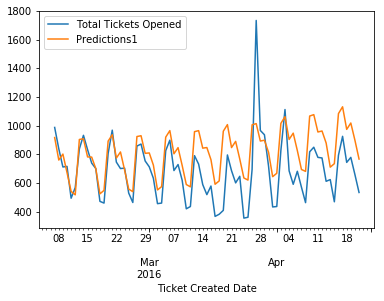

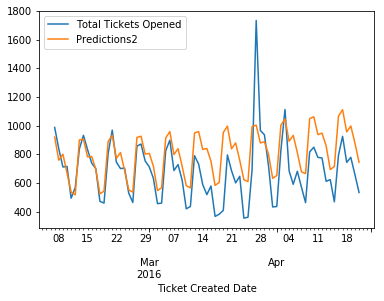

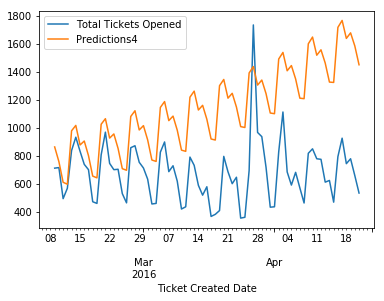

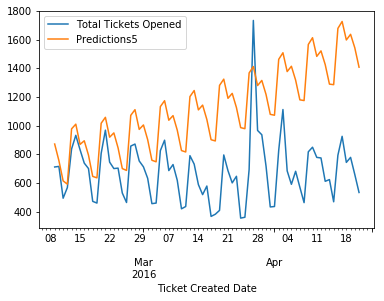

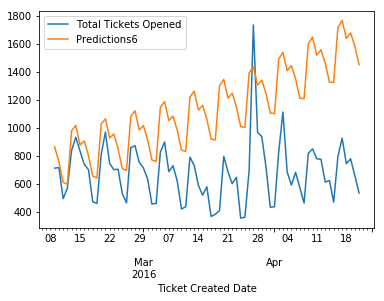

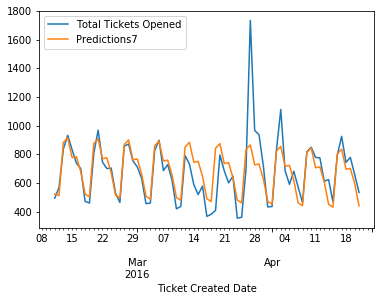

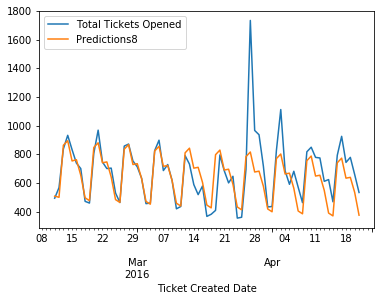

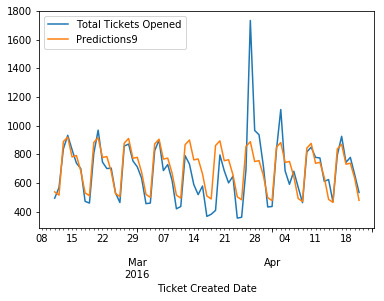

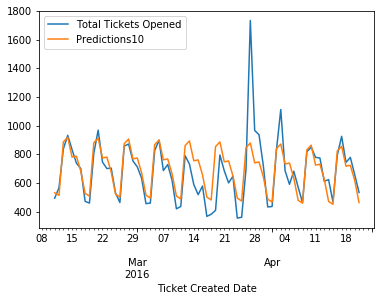

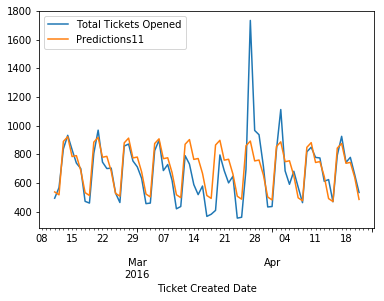

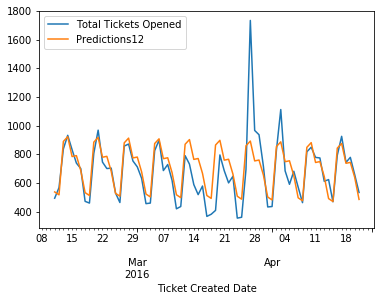

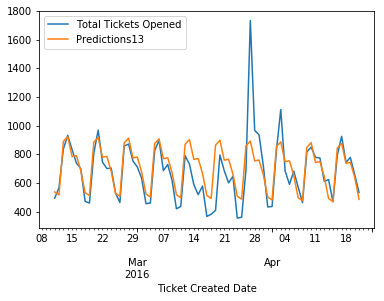

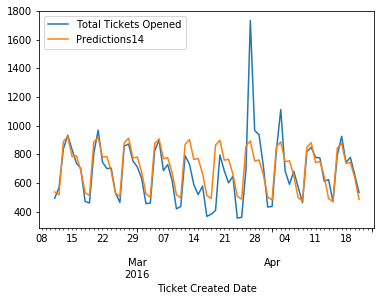

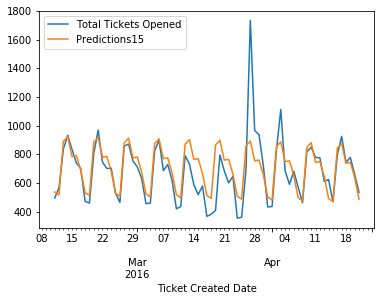

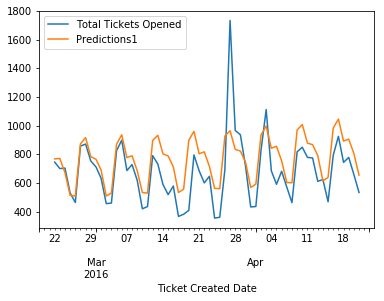

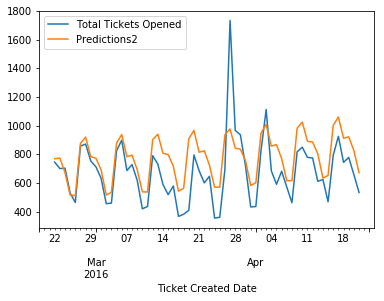

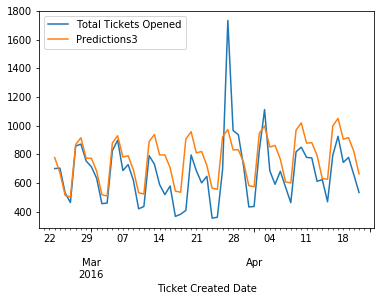

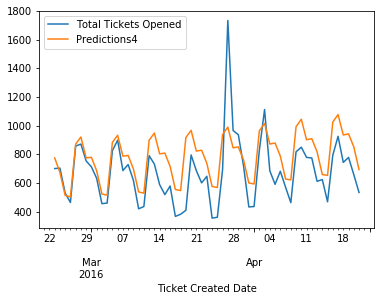

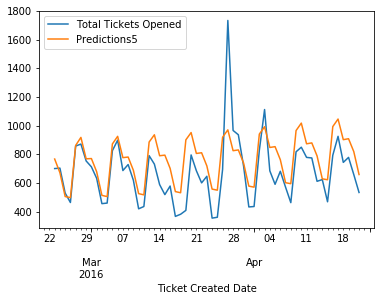

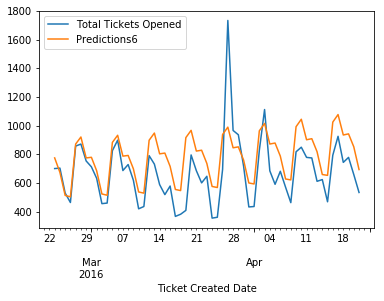

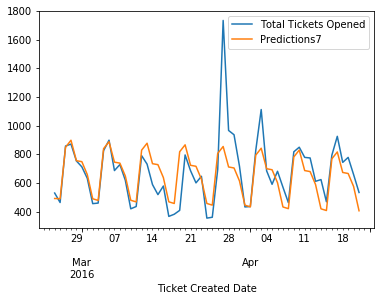

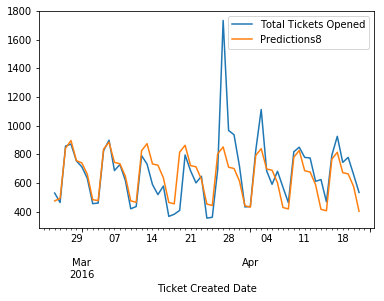

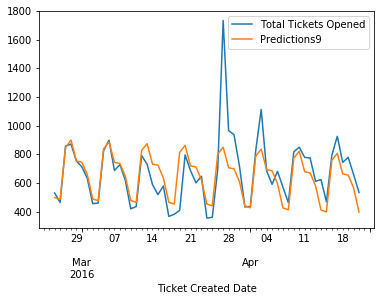

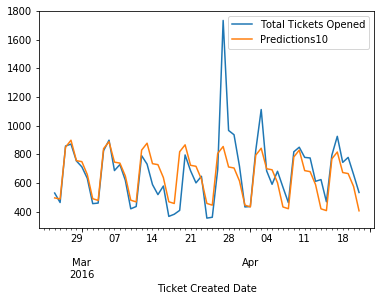

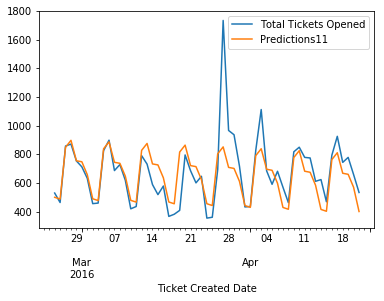

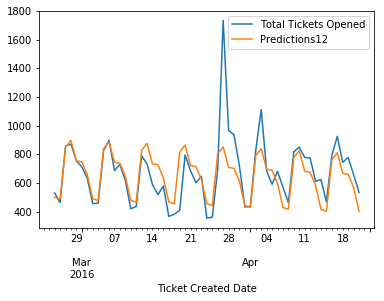

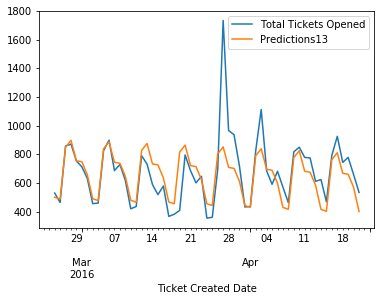

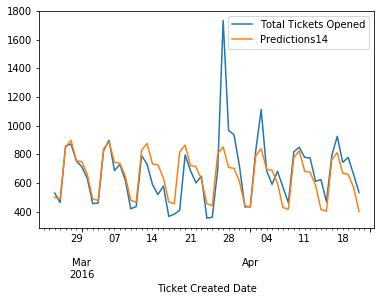

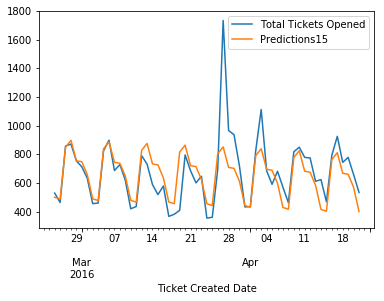

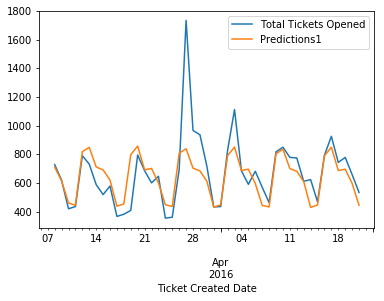

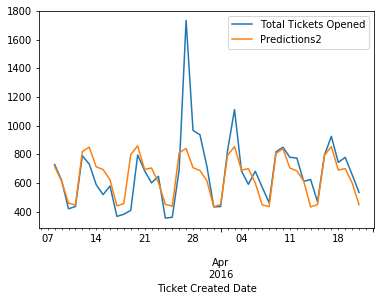

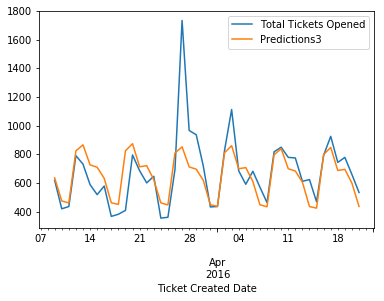

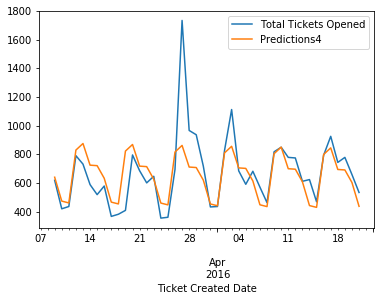

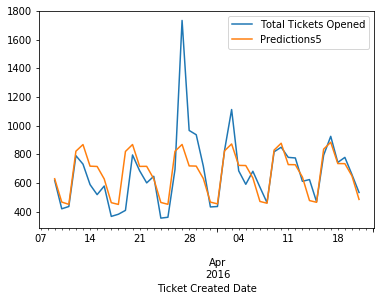

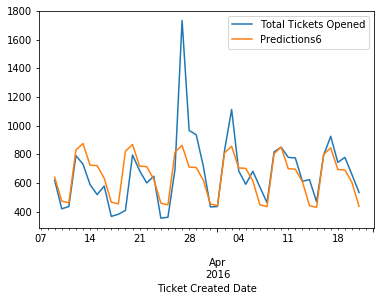

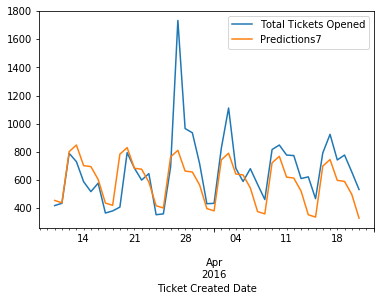

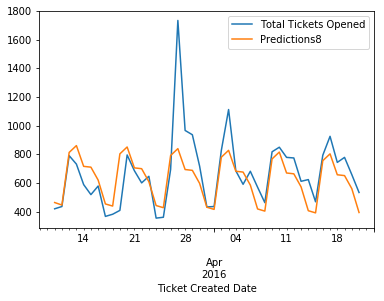

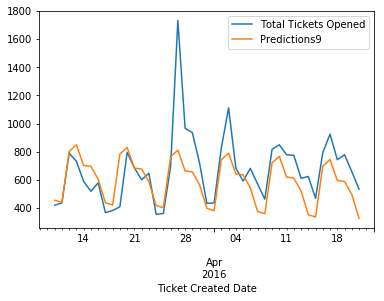

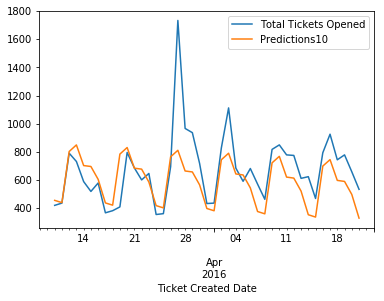

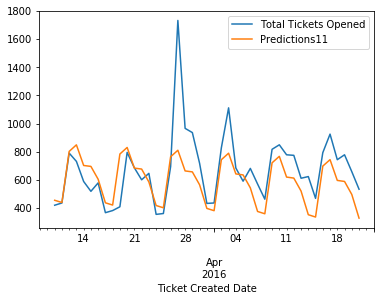

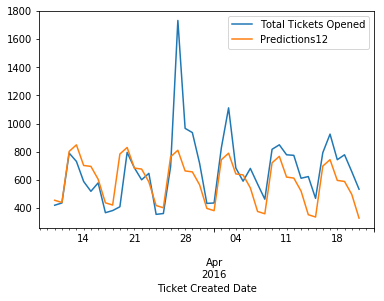

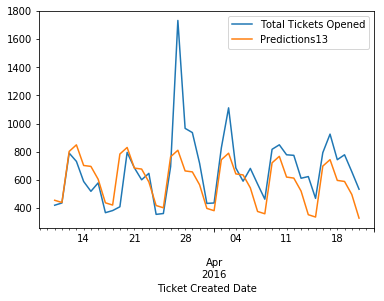

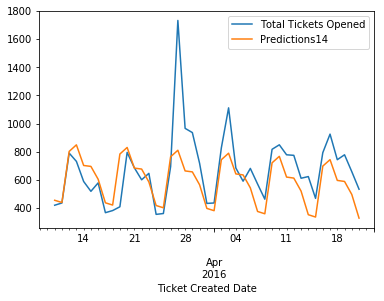

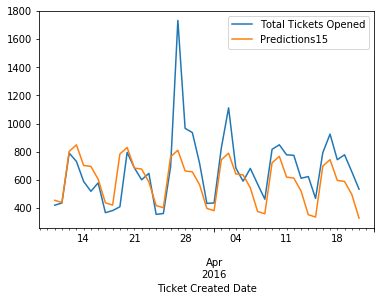

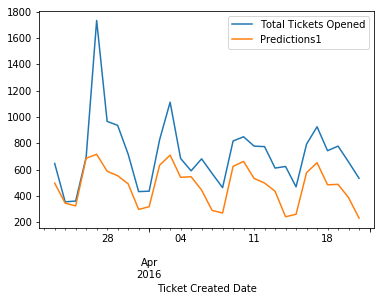

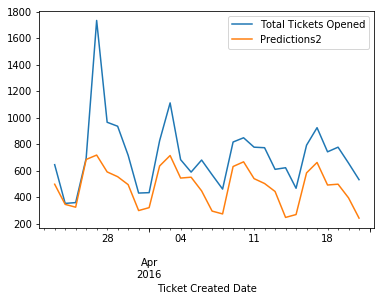

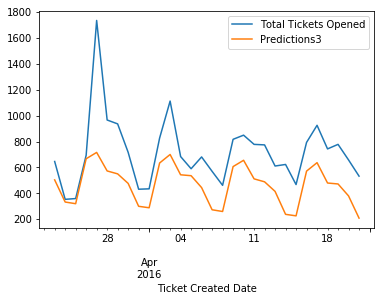

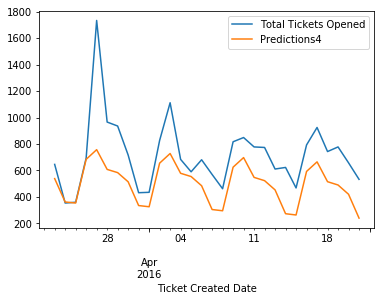

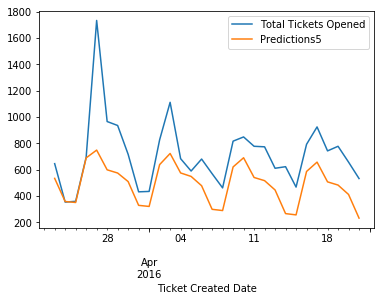

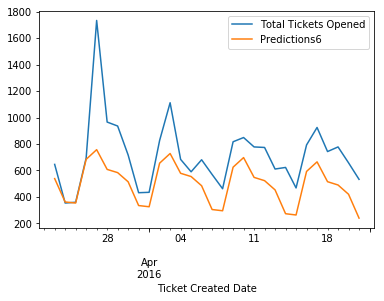

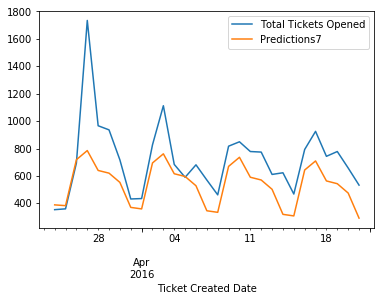

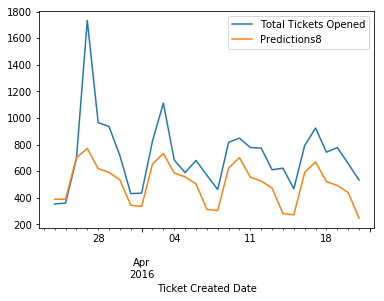

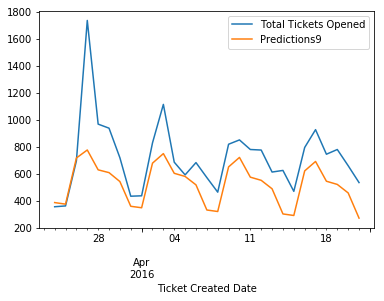

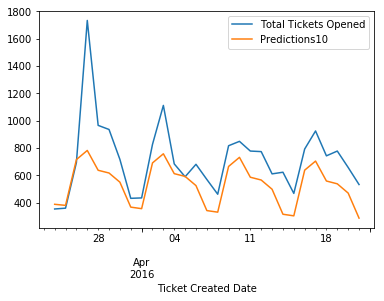

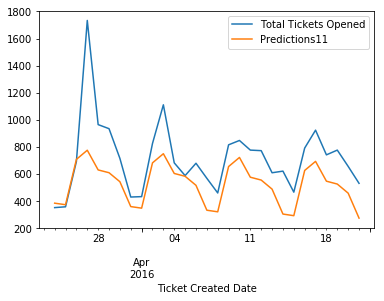

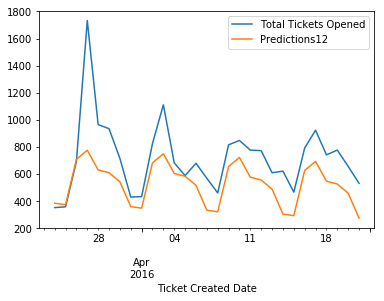

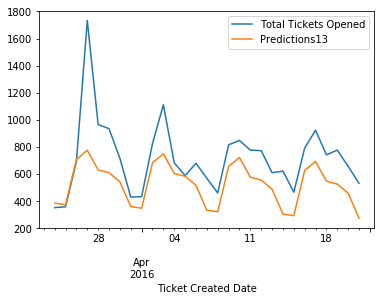

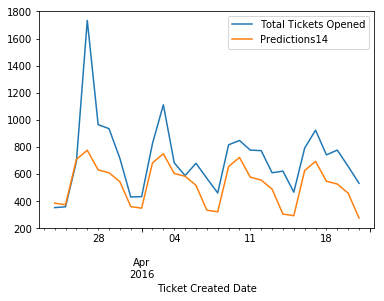

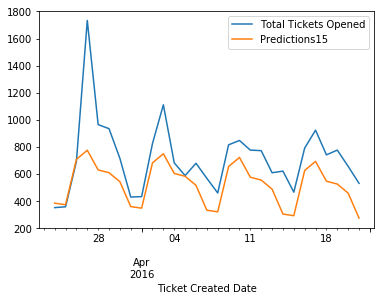

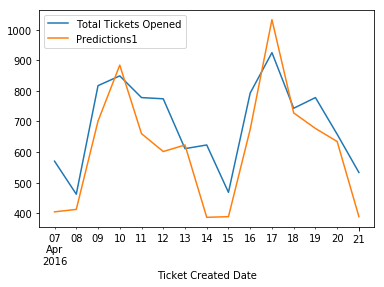

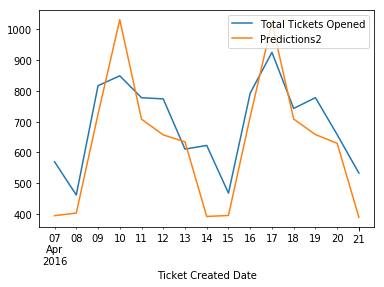

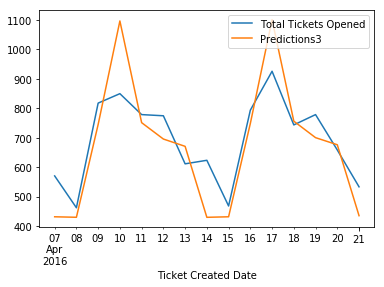

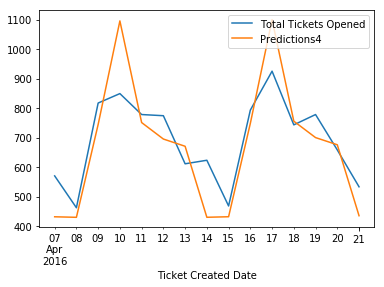

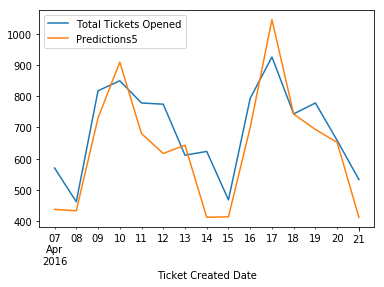

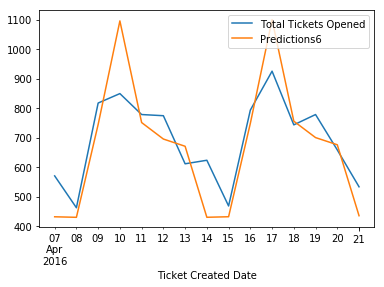

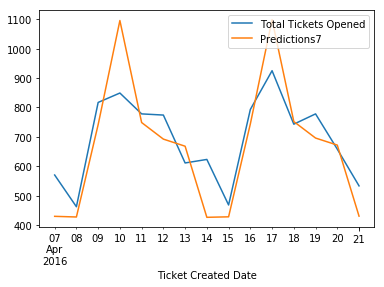

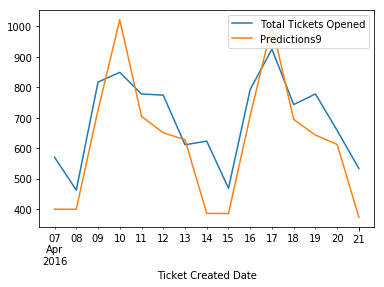

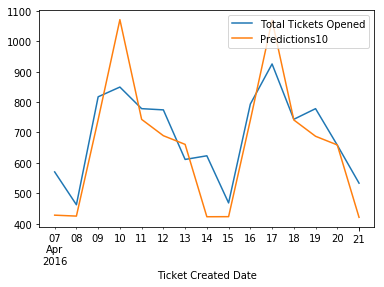

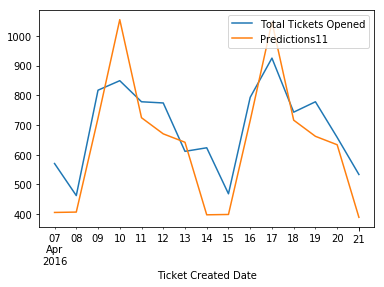

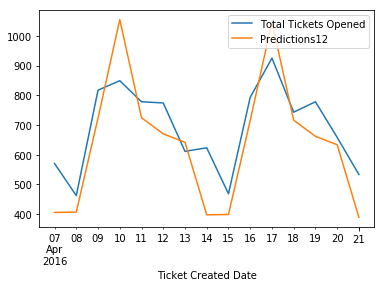

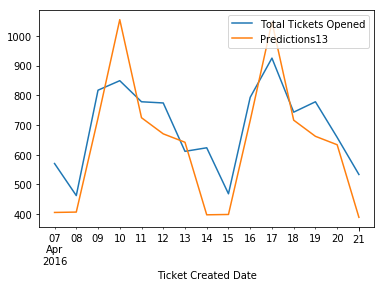

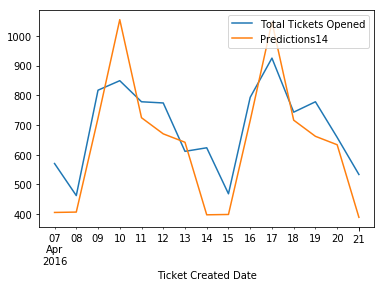

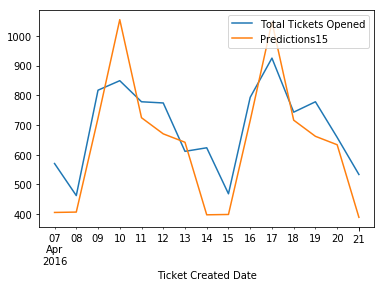

In [135]:
s_results, all_preds = aa_model(df)

In [136]:
s_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [144.2328086814121,
  160.8881992505998,
  172.62799052351664,
  253.80517569780767,
  102.36247648082143]}

# Model Evaluations

In [226]:
def create_results_df(results1, results2, results3):
    temp_df = pd.DataFrame(results1['Splits'])
    temp_df['Seasonal Persistance'] = results1['RMSE']
    temp_df['Holts Winter'] = results2['RMSE']
    temp_df['SARIMAX'] = results3['RMSE']
    temp_df = temp_df.rename(columns={0:'Training Split'}).set_index(['Training Split']).T
    temp_df['Mean RMSE'] = temp_df.mean(axis=1)
    return temp_df

In [227]:
results_df = create_results_df(sp_results, hw_results, s_results)

In [228]:
results_df

Training Split,0.5,0.6,0.7,0.8,0.9,Mean RMSE
Seasonal Persistance,141.692024,155.714358,176.688184,176.400354,56.481042,141.395192
Holts Winter,143.757992,155.024280,172.558173,241.102578,109.124133,164.313431
SARIMAX,144.232809,160.888199,172.627991,253.805176,102.362476,166.783330


# Make Forecast w/ Seasonal Persistence

In [241]:
def seasonal_persistence_forecast(df):
    train_size = len(df) - 14
    train, test = df[:train_size], df[train_size:]
    # Evaluate up to the last 30 weeks mean
    weeks = [i for i in range(1,30)]
    best_rmse = 10000
    for week in weeks:
        try:
            # Walk forward validation
            history = [x for x in train.values]
            predictions = []
            for i in range(len(test)):
                #collect observation
                obs = []
                for d in range(1, week+1):
                    obs.append(history[-(d*7)])
                #make prediction
                yhat = np.mean(obs)
                predictions.append(yhat)
                # Observation
                history.append(test[i])
            future_forecast = pd.DataFrame(predictions,
                               index=test.index,
                               columns=['Predictions'])
            rmse = sqrt(mean_squared_error(test, predictions))
            if rmse < best_rmse:
                best_rmse = rmse
                best_forecast = pd.concat([test, future_forecast], axis=1)
            else:
                continue
        except:
            break
    return best_rmse, best_forecast

In [242]:
sp_rmse, sp_forecast = seasonal_persistence_forecast(df['Total Tickets Opened'])

In [243]:
sp_rmse

55.09421212633345

In [244]:
sp_forecast

,Total Tickets Opened,Predictions
Ticket Created Date,,
2016-04-08,462,488.8750
2016-04-09,817,833.8125
2016-04-10,849,969.8750
2016-04-11,778,770.1250
2016-04-12,774,750.9375
2016-04-13,611,678.6250
2016-04-14,623,493.3125
2016-04-15,468,474.0625
2016-04-16,793,821.6875


## Step forward

# Scheduler

## Scheduler Functions


In [250]:
sp_forecast['Predictions']

Ticket Created Date
2016-04-08    488.8750
2016-04-09    833.8125
2016-04-10    969.8750
2016-04-11    770.1250
2016-04-12    750.9375
2016-04-13    678.6250
2016-04-14    493.3125
2016-04-15    474.0625
2016-04-16    821.6875
2016-04-17    961.3750
2016-04-18    759.7500
2016-04-19    746.7500
2016-04-20    670.3750
2016-04-21    496.9375
Name: Predictions, dtype: float64

In [245]:
# Get phone hours based on forecast
def get_phone_hours(t_count):
    aht = 20 # average handle time in minutes
    exp_phone_tickets = .3 * t_count # expected phone tickets
    expected_hours = exp_phone_tickets * aht / 60 # expected hours
    return expected_hours

In [246]:
# Get chat hours based on forecast
def get_chat_hours(t_count):
    aht = 10 # average handle time in minutes
    exp_chat_tickets = .5 * t_count # expected phone tickets
    expected_hours = exp_chat_tickets * aht / 60 # expected hours
    
    return expected_hours

In [247]:
# Get email hours based on forecast
def get_email_hours(t_count):
    aht = 6 # average handle time in minutes
    exp_email_tickets = .2 * t_count # expected phone tickets
    expected_hours = exp_email_tickets * aht / 60 # expected hours
    return expected_hours

In [260]:
# Use the above functions to calculate total hours
def get_total_hours(t_count):
    phone_hours = get_phone_hours(t_count)
    chat_hours = get_chat_hours(t_count)
    email_hours = get_email_hours(t_count)
    total_hours = (phone_hours + chat_hours + email_hours) / .85  # Expect workers to productive .85 percent of the time
    return total_hours

In [301]:
def get_shifts(ticket_forecast):
    shift_requirements = [int(get_total_hours(x)/8) for x in ticket_forecast]
    shift_list = [str(x) for x in sp_forecast.index.date]
    return shift_requirements, shift_list

In [312]:
sp_forecast

,Total Tickets Opened,Predictions
Ticket Created Date,,
2016-04-08,462,488.8750
2016-04-09,817,833.8125
2016-04-10,849,969.8750
2016-04-11,778,770.1250
2016-04-12,774,750.9375
2016-04-13,611,678.6250
2016-04-14,623,493.3125
2016-04-15,468,474.0625
2016-04-16,793,821.6875


In [315]:
analyze_df = sp_forecast

In [317]:
def analyze_shifts(df):
    temp_df = df
    sr, sl = get_shifts(temp_df['Predictions'])
    ar, al = get_shifts(temp_df['Total Tickets Opened'])
    temp_df['Forecasted Shift Requirements'] = sr
    temp_df['Actual Shift Requirements'] = ar
    temp_df['Difference'] = temp_df['Actual Shift Requirements'] - temp_df['Forecasted Shift Requirements']
    return temp_df[['Actual Shift Requirements', 'Forecasted Shift Requirements', 'Difference']]

In [318]:
# Shows the difference in shift requirements based on actual data v forecasted data
analyze_shifts(analyze_df)

,Actual Shift Requirements,Forecasted Shift Requirements,Difference
Ticket Created Date,,,
2016-04-08,13,14,-1
2016-04-09,24,24,0
2016-04-10,25,29,-4
2016-04-11,23,23,0
2016-04-12,23,22,1
2016-04-13,18,20,-2
2016-04-14,18,14,4
2016-04-15,13,14,-1
2016-04-16,23,24,-1


In [300]:
def scheduler(ticket_forecast):
    ## Create a list of workers
    workerList = ['Employee' + str(x) for x in range(1,36)]

    # Define shift requirements
    shiftRequirements  = { s : shiftReq[i] for i,s in enumerate(shiftList) }
    shiftReq, shiftList = get_shifts(ticket_forecast)

    # Clarify worker availability for each worker
    availability = pd.DataFrame(np.ones((len(workerList), len(shiftList))), index=workerList, columns=shiftList)

    # Create dictionary of final worker availability
    avail = {(w,s) : availability.loc[w,s] for w in workerList for s in shiftList}

    ## Input assumptions
    # Range of shifts that every workers is required to stay between
    minShifts = 6
    maxShifts = 10
    
    m = Model('Scheduler')
    
    # Assignment variables: x[w,s] == 1 if worker w is assigned to shift s.
    x = m.addVars(avail, vtype=GRB.BINARY, name='x')
    
    # Slack variables for each shift constraint so that the shifts can be satisfied
    slacks = m.addVars(shiftList, name='Slack')

    # Variable to represent the total slack
    totalSlack = m.addVar(name='totalSlack' )

    # Variables to count the total shifts worked by each other
    totalShifts = m.addVars(workerList, name='totalShifts')

    # Constraint: Ensure each worker stays within min and max shift bounds
    minShiftsConstr = m.addConstrs(((
        x.sum(w,'*') >= minShifts for w in workerList)
        ), name='minShifts')

    maxShiftsConstr = m.addConstrs(((
        x.sum(w,'*') <= maxShifts for w in workerList)
        ), name='maxShifts')

    # Constraint: assign exactly shiftRequirement[s] workers to each shift s, plus the slack
    reqCts = m.addConstrs((
        slacks[s] + x.sum('*', s) == shiftRequirements[s] 
        for s in shiftList), '_')

    # Constraint: set totSlack equal to the total slack
    m.addConstr(totalSlack == slacks.sum(), 'totalSlack')

    # Constraint: compute the total number of shifts for each worker
    m.addConstrs((
        totalShifts[w] == x.sum(w) 
        for w in workerList), 'totalShifts')

    # Objective: minimize the total slack
    m.setObjective(totalSlack)

    m.optimize()

    sol = pd.DataFrame(data={'Solution':m.X}, index=m.VarName)
    sol = sol.iloc[0:len(x)]

    dashboard = pd.DataFrame(index = workerList, columns = shiftList)
    for w in workerList:
        for s in shiftList:
            dashboard.at[w,s] = sol.loc['x['+w+','+s+']',][0]

    return dashboard

In [272]:
scheduler(sp_forecast['Predictions'])

Optimize a model with 120 rows, 540 columns and 2024 nonzeros
Variable types: 50 continuous, 490 integer (490 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 3e+01]
Found heuristic solution: objective 40.0000000
Presolve removed 36 rows and 36 columns
Presolve time: 0.00s
Presolved: 84 rows, 504 columns, 1484 nonzeros
Variable types: 0 continuous, 504 integer (490 binary)

Root relaxation: objective 0.000000e+00, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 0 nodes (56 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 0 40 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, bes

,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21
Employee1,1,1,1,-0,-0,1,1,1,1,-0,-0,1,1,1
Employee2,1,1,1,-0,-0,1,1,1,-0,1,1,-0,1,1
Employee3,1,1,-0,-0,-0,1,-0,1,1,-0,1,-0,-0,1
Employee4,1,-0,1,1,-0,-0,1,1,-0,-0,0,-0,-0,1
Employee5,1,1,-0,-0,-0,1,1,1,-0,-0,-0,1,1,1
Employee6,-0,-0,1,-0,-0,1,1,1,1,-0,-0,-0,1,1
Employee7,-0,-0,1,-0,1,-0,1,1,1,1,-0,-0,-0,0
Employee8,1,1,1,-0,-0,1,-0,-0,1,-0,-0,-0,1,1
Employee9,-0,-0,-0,-0,-0,1,1,-0,-0,1,1,-0,1,1
Employee10,-0,-0,1,-0,1,-0,-0,1,1,1,1,-0,1,1


# THE END